In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
import functions as fc
import os
from Metropolis import Metropolis  #  On importe la classe.
from tqdm import tqdm # Pour afficher où on est rendu dans la série de simulations.

data_folder = "Data/" # Ne pas oublier le "/" après. Si en windows, c'est "\"
top_dir = os.getcwd()
plt.rcParams['font.size'] = 14

## TODO
* Code pour calculer la taille des composantes (îlots) -> varier la dimension de la grille pour betaJ fixé afin de voir l'effet sur la distribution
* Boucle d'hystérésis avec fill_between pour variabilité selon seeds différentes (mémorisées)
* 

## 1 - Simulation exploratoire

In [2]:
start_time = time.time()

#metro = Metropolis(lattice_size=64, betaJ=0.7, magnetic_field=0.0, pourcentage_up=0)

#metro.plot_hysteresis(h_low=-2, h_high=2, resolution=0.1, fast=True)

# Créer une instance de la classe Metropolis avec les paramètres souhaités
# def __init__(self, lattice_size, betaJ, magnetic_field, energy=None, previous_lattice=None, pourcentage_up=0.60, seed=None):

metro = Metropolis(lattice_size=64, 
                    magnetic_field=0.1, 
                    betaJ=1, 
                    pourcentage_up=0.6, 
                    seed=42,
                    )

#def find_equilibrium(self, n_iter=30000, buffer = 5000, run_max=True, fluct_eq=0.002, fast=True, save_all=False):
#list_lattices, energy, spin_mean_list, energy_list

# Trouver l'état d'équilibre en utilisant la méthode "find_equilibrium"
lattices, energy, spin_means, energy_list = metro.find_equilibrium()
step_algo = np.arange(0, len(spin_means), 1) # Itérations de la "descente" Metropolis

print("Temps d'exécution : ", time.time() - start_time)


Temps d'exécution :  1.311206340789795


<Figure size 1200x400 with 0 Axes>

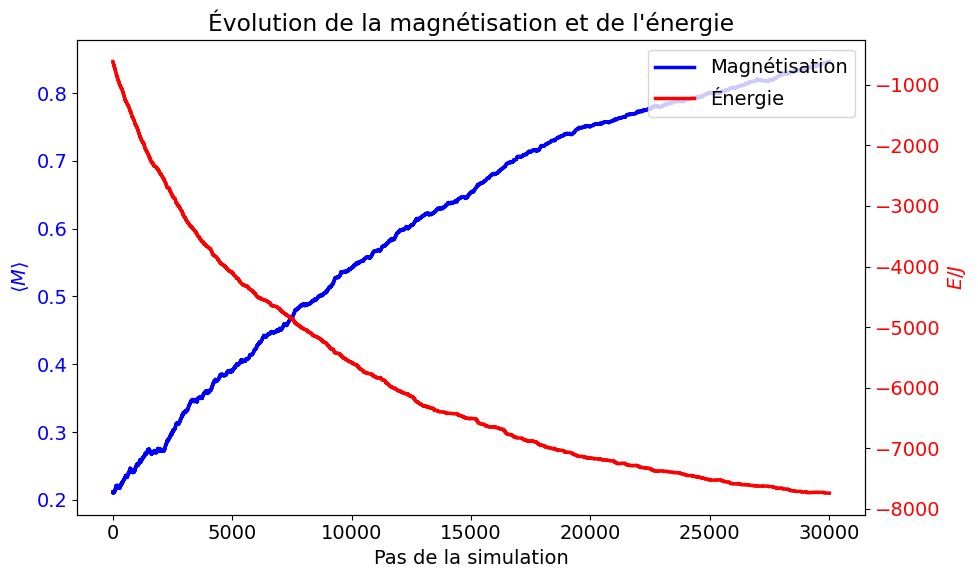

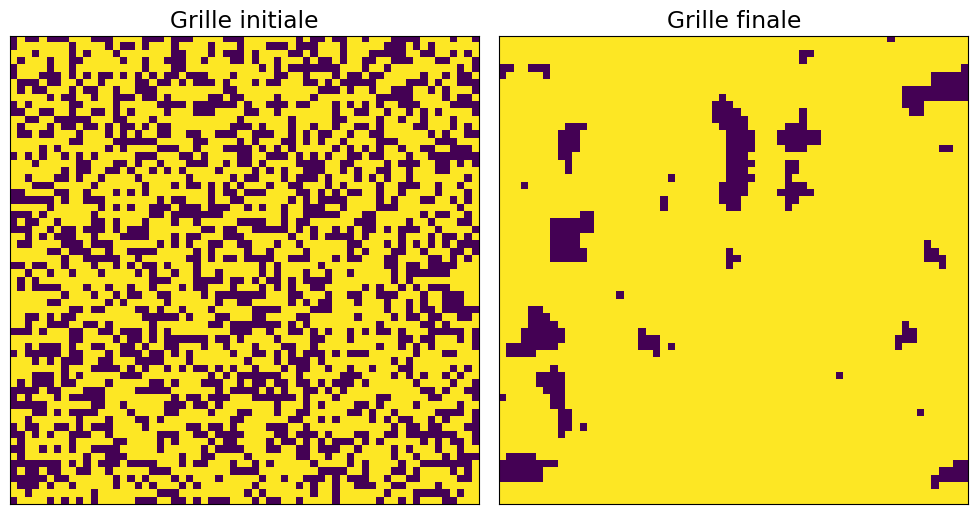

In [3]:
plt.figure(figsize=(12, 4))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(step_algo, spin_means, 'b-', linewidth=2.5, label='Magnétisation')
ax1.set_xlabel("Pas de la simulation")
ax1.set_ylabel(r"$\langle M \rangle$", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(step_algo, energy_list, 'r-', linewidth=2.5, label='Énergie')
ax2.set_ylabel(r"$E/J$", color='r')
ax2.tick_params(axis='y', labelcolor='r')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title("Évolution de la magnétisation et de l'énergie")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(lattices[0], vmin=-1, vmax=1)
plt.title("Grille initiale")
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(lattices[-1], vmin=-1, vmax=1)
plt.title("Grille finale")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## 2 - Simulation d'une série à betaJ fixé

1) Faire un dossier pour chaque série de simulations, quelle qu'elle soit. 
2) Enregistrer les multiples simuls pour aller chercher la variabilité de type (incertitude de type A) dans un même hdf5. 
3) Nouveau hdf5 pour nouvelle valeur de champ $h$ ou de tout autre paramètre, par exemple le pourcentage de spin up à l'état initial.
4) Faire un dossier différent pour chaque valeur de température ($\beta J$) essayée -> Permettra de calculer l'aire de la boucle d'hystérésis selon $\beta J$. 

In [4]:
def run_batch_simulations(h_vec, n_seeds, base_path, betaJ=0.5, size=64, enreg=True):

    file_suffix=".h5"

    seed_stack = []
    mag_f_vec_stack = []
    E_f_vec_stack = []
    grille_f_vec_stack = []

    for i in range(n_seeds):
        seed = int(i+1) # Arbitrairement, on injecte i comme seed!
        seed_stack.append(i)
        derniere_grille = None # On réinitialise la grille à chaque seed, pour une nouvelle boucle d'hystérésis

        mag_f_vec = [] # Vecteur de <M>_f selon vecteur de h (pour seed donnée)
        E_f_vec = [] # Vecteur de E_f selon vecteur de h (pour seed donnée)
        grille_f_vec = [] # Liste contenant les grilles finales, pour chaque h balayé

        metro = Metropolis(lattice_size=size,
            magnetic_field = 0,
            betaJ = betaJ, 
            pourcentage_up = 0.5, 
            seed=seed,
            )

        for h in tqdm(h_vec, desc="Variation du champ magnétique"):

            metro.h = h # Mise à jour du champ magnétique
            metro.previous_lattice = derniere_grille
            lattices_timeseries, _, mag_timeseries, energy_timeseries = metro.find_equilibrium()

            mag_f_vec.append(mag_timeseries[-1])
            E_f_vec.append(energy_timeseries[-1])
            derniere_grille = lattices_timeseries[-1] # Enregistrement de la dernière grille, pour repartir d'elle comme condition initiale
            grille_f_vec.append(derniere_grille)

        mag_f_vec_stack.append(mag_f_vec)
        E_f_vec_stack.append(E_f_vec)
        grille_f_vec_stack.append(grille_f_vec)

    if enreg:
        # Fichier propre à chaque seed
        filename = f"{base_path}{file_suffix}"
        print("Enregistrement de " + filename)

        data_dict = {
            # Éléments dynamiques, propres à aux simulations individuelles
            "grille_f": np.array(grille_f_vec_stack),
            "E_f": np.array(E_f_vec_stack),
            "M_f": np.array(mag_f_vec_stack),
            "betaJ": np.array([metro.betaJ]),
            "h": np.array(h_vec),

            # Éléments statiques, propres à la batch de simuls
            "seed" : seed_stack,
            "pourcentage_up": metro.up_perc
        }

        fc.save_hdf5(filename, data_dict)

    return np.array(mag_f_vec_stack), np.array(E_f_vec_stack), np.array(grille_f_vec_stack)


In [5]:
enreg=False
simulation_type = "hysteresis" # hysteresis, ou quelque chose d'autre (à suivre)
branche_n_points = 5
h_low = -1
h_high = 1
close_loop = True

h_vec = np.concatenate([np.linspace(0, h_high, branche_n_points), np.linspace(h_high, h_low, branche_n_points*2 + 1), np.linspace(h_low, h_high, 2*branche_n_points+1)])
betaJ = 0.05

print("betaJ : ", betaJ)
print("Simulation : ", simulation_type)
print("Valeurs de h balayées :", h_vec)

betaJ :  0.05
Simulation :  hysteresis
Valeurs de h balayées : [ 0.    0.25  0.5   0.75  1.    1.    0.8   0.6   0.4   0.2   0.   -0.2
 -0.4  -0.6  -0.8  -1.   -1.   -0.8  -0.6  -0.4  -0.2   0.    0.2   0.4
  0.6   0.8   1.  ]


In [6]:
sim_id = len(fc.identify_files(top_dir+"/Data", keywords=[simulation_type]))
sim_folder = top_dir + "/Data/" + simulation_type + f"_betaJ={betaJ}".format(sim_id)

if enreg:
    fc.create_folder(sim_folder)

filename = sim_folder + "/" + "simul_" + simulation_type # Juste le noyau du nom de fichier
mag_data, Ef_data, grille_data = run_batch_simulations(h_vec, n_seeds=3, betaJ=betaJ, base_path=filename, enreg=enreg)

Variation du champ magnétique: 100%|██████████| 27/27 [00:03<00:00,  7.60it/s]


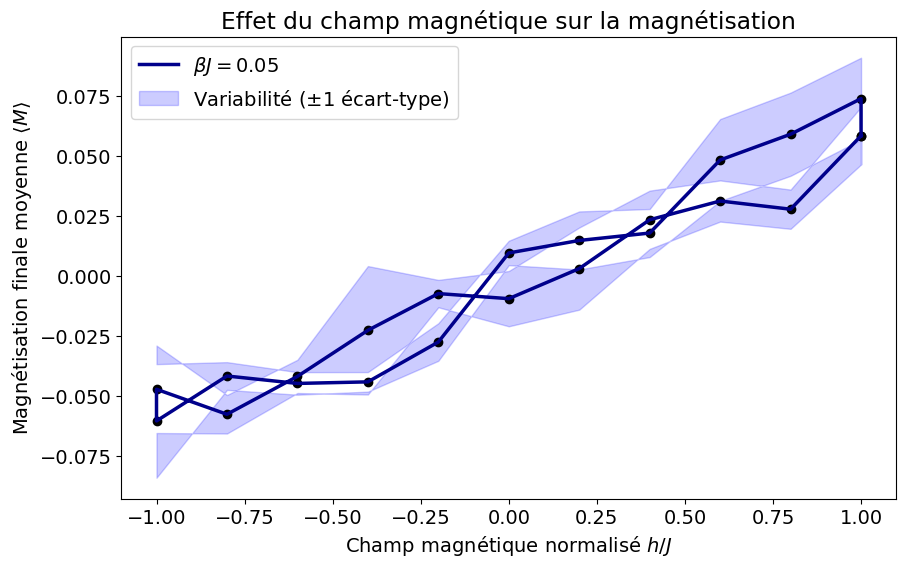

In [ ]:
# Retirer les 4 premiers points pour éviter de voir la branche initiale de magnétisation
h_vec_filtered = h_vec[branche_n_points:]
mean_mag = np.mean(mag_data, axis=0)
std_mag = np.std(mag_data, axis=0)
mean_mag_filtered = mean_mag[branche_n_points:]
std_mag_filtered = std_mag[branche_n_points:]

if close_loop: 
    h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
    mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
    std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

plt.figure(figsize=(10,6))
plt.plot(h_vec_filtered, mean_mag_filtered, color="darkBlue", linewidth=2.5, label=r"$\beta J = $" + f"{betaJ:.2f}")
plt.fill_between(h_vec_filtered, 
                 mean_mag_filtered - std_mag_filtered, 
                 mean_mag_filtered + std_mag_filtered, 
                 color="blue", alpha=0.2, label=r"Variabilité ($\pm 1$ écart-type)")
plt.scatter(h_vec_filtered, mean_mag_filtered, color="black")
plt.xlabel(r"Champ magnétique normalisé $h/J$")
plt.ylabel(r"Magnétisation finale moyenne $\langle M \rangle $")
plt.title("Effet du champ magnétique sur la magnétisation")
plt.xlim(1.1*h_low, 1.1*h_high)
plt.legend()
plt.show()

# 3.1 - Simulations en séries pour plusieurs boucles d'hystérèse

In [6]:
enreg=True
n_seeds = 10
simulation_type = "hysteresis" # hysteresis, ou quelque chose d'autre (à suivre)
branche_n_points = 8
h_low = -1
h_high = 1
close_loop = True

#h_list = np.concatenate((np.arange(h_low, h_high, resolution), np.arange(h_high, h_low, -resolution)))

h_vec = np.concatenate([np.linspace(0, h_high, branche_n_points), np.linspace(h_high, h_low, branche_n_points*2 + 1), np.linspace(h_low, h_high, 2*branche_n_points+1)])
print("Simulation : ", simulation_type)
print("Valeurs de h balayées :", h_vec)

# On balaye aussi les betaJ pour la figure avec plusieurs boucles d'hystérèse
betaJ_vec = np.linspace(0.1, 1, 10)
print("betaJ : ", betaJ_vec)

Simulation :  hysteresis
Valeurs de h balayées : [ 0.          0.14285714  0.28571429  0.42857143  0.57142857  0.71428571
  0.85714286  1.          1.          0.875       0.75        0.625
  0.5         0.375       0.25        0.125       0.         -0.125
 -0.25       -0.375      -0.5        -0.625      -0.75       -0.875
 -1.         -1.         -0.875      -0.75       -0.625      -0.5
 -0.375      -0.25       -0.125       0.          0.125       0.25
  0.375       0.5         0.625       0.75        0.875       1.        ]
betaJ :  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00
betaJ :  0.1


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.10.h5


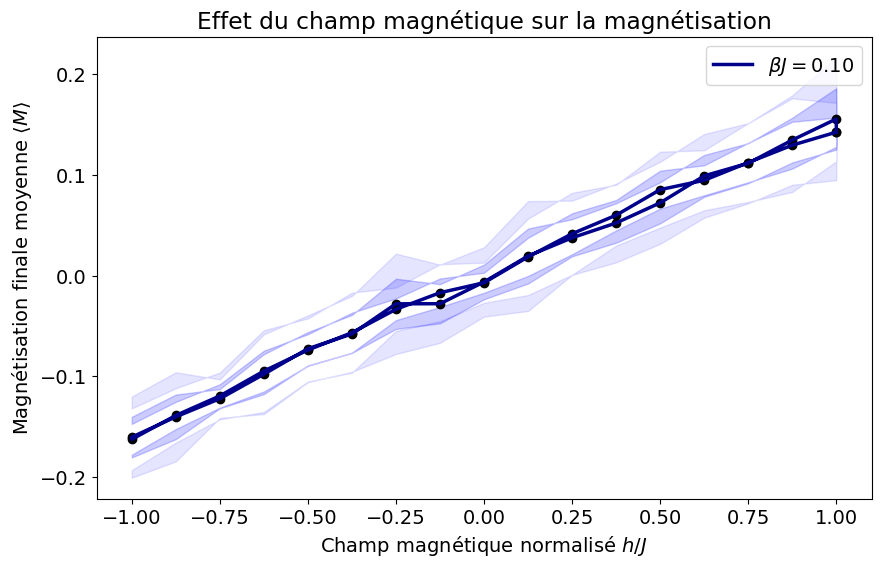

betaJ :  0.2


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.20.h5


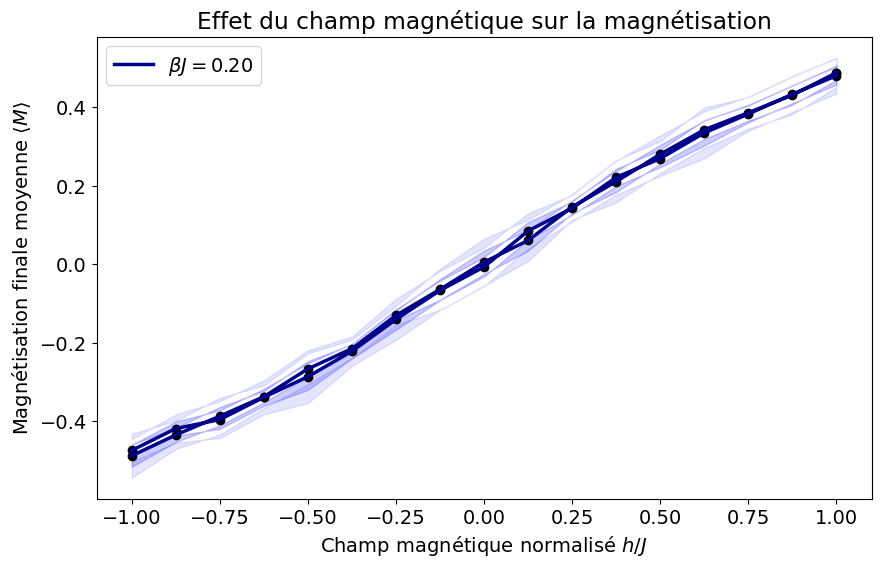

betaJ :  0.30000000000000004


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.30.h5


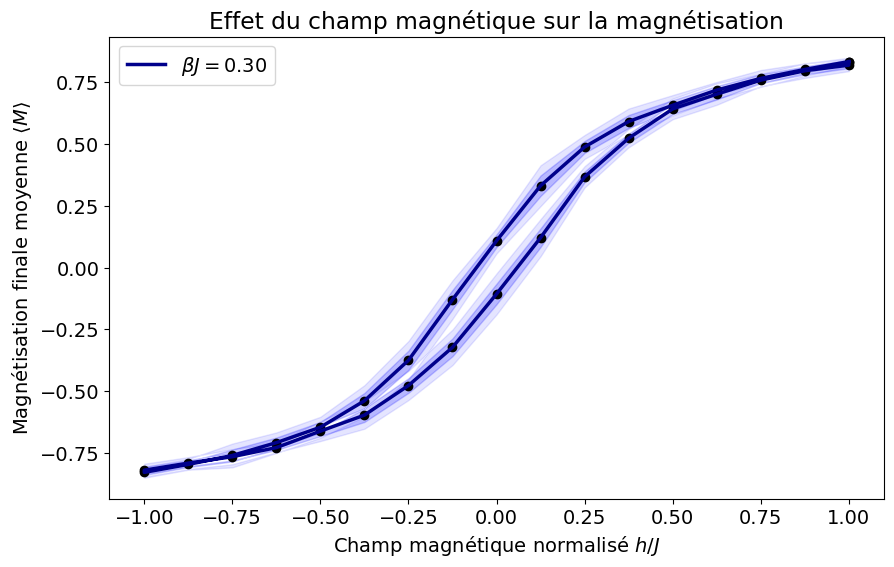

betaJ :  0.4


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.40.h5


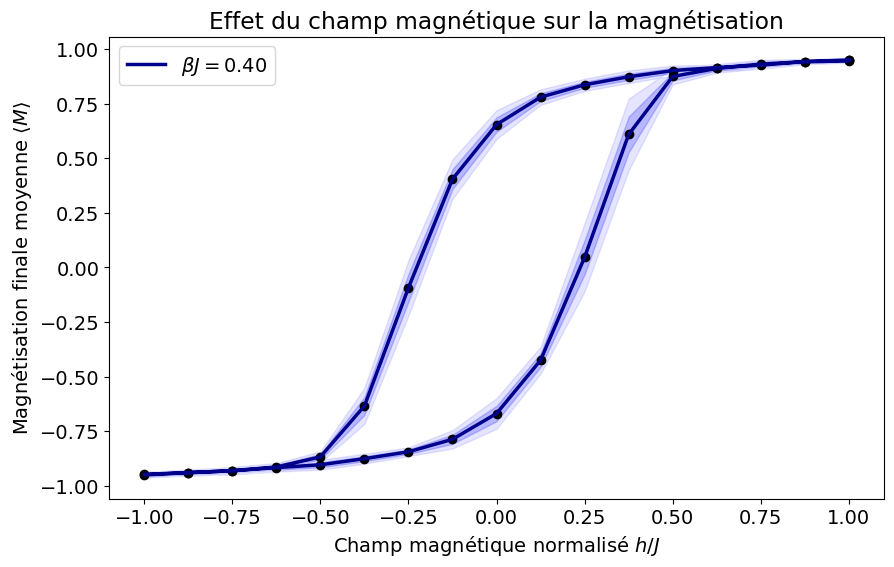

betaJ :  0.5


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.50.h5


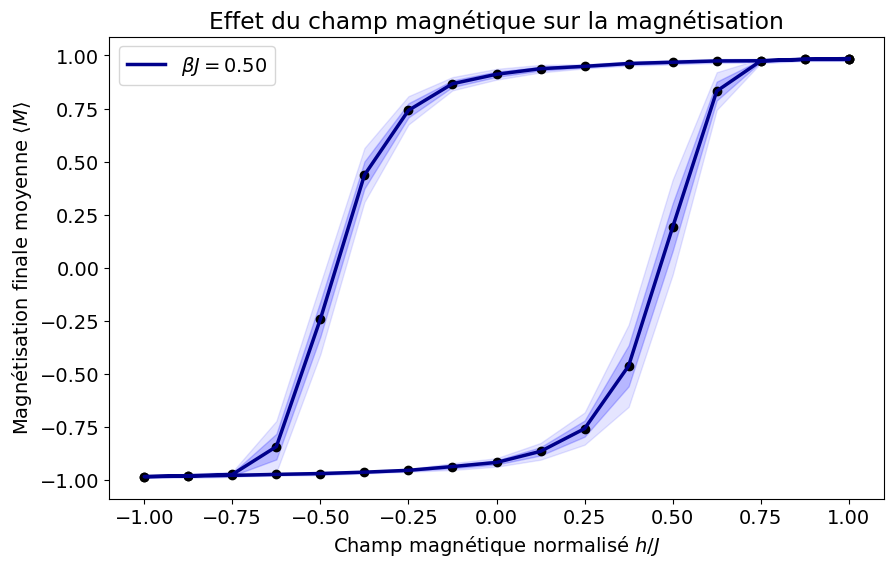

betaJ :  0.6


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.60.h5


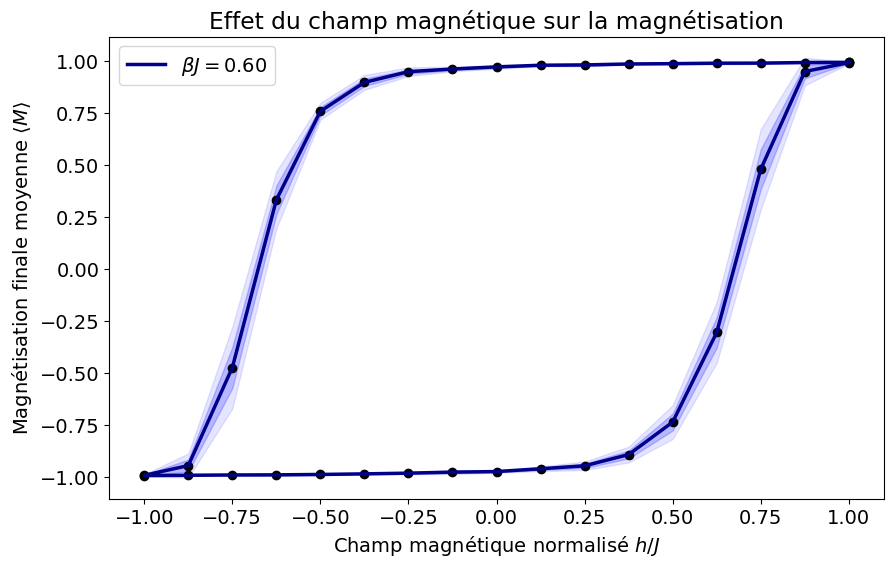

betaJ :  0.7000000000000001


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.70.h5


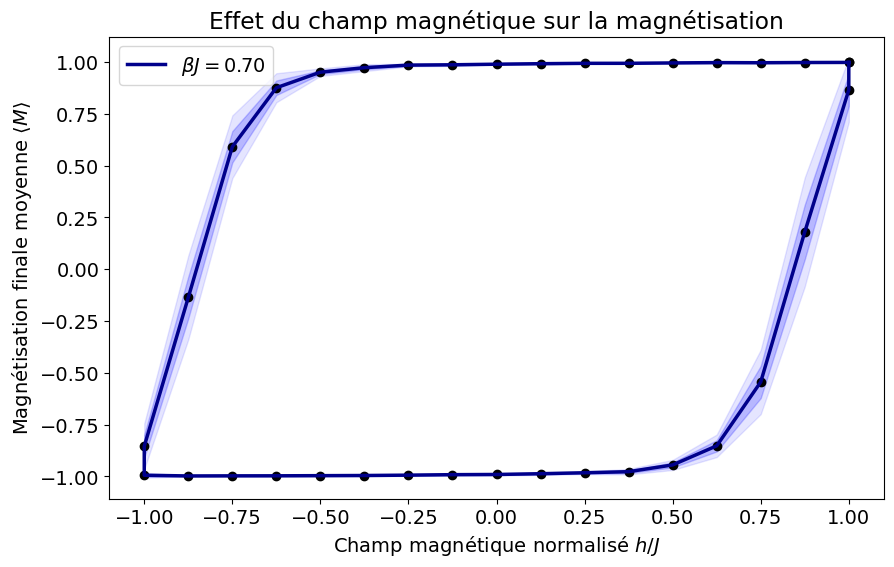

betaJ :  0.8


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.80.h5


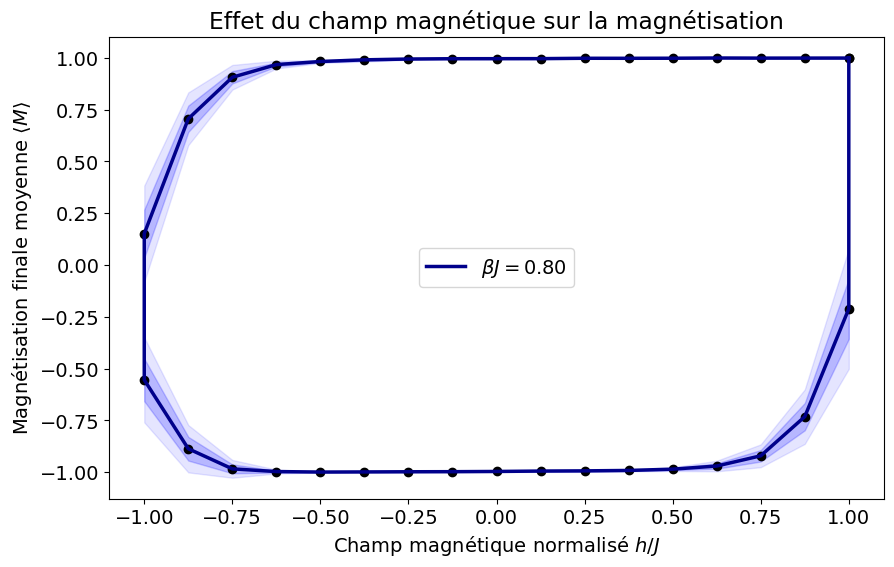

betaJ :  0.9


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=0.90.h5


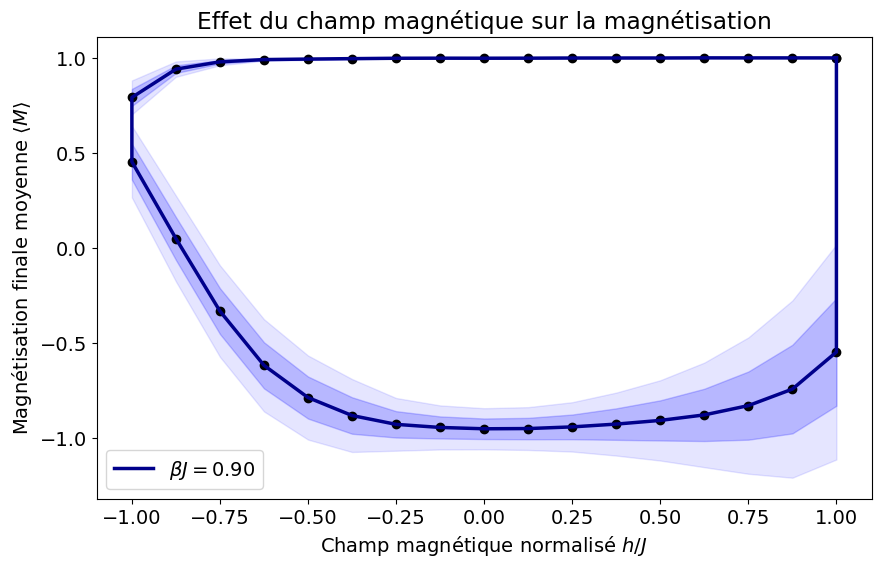

betaJ :  1.0


Variation du champ magnétique: 100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


Enregistrement de /home/arleg/Documents/GitHub/physnum_h25/physnum25/Data/hysteresis_00/simul_betaJ=1.00.h5


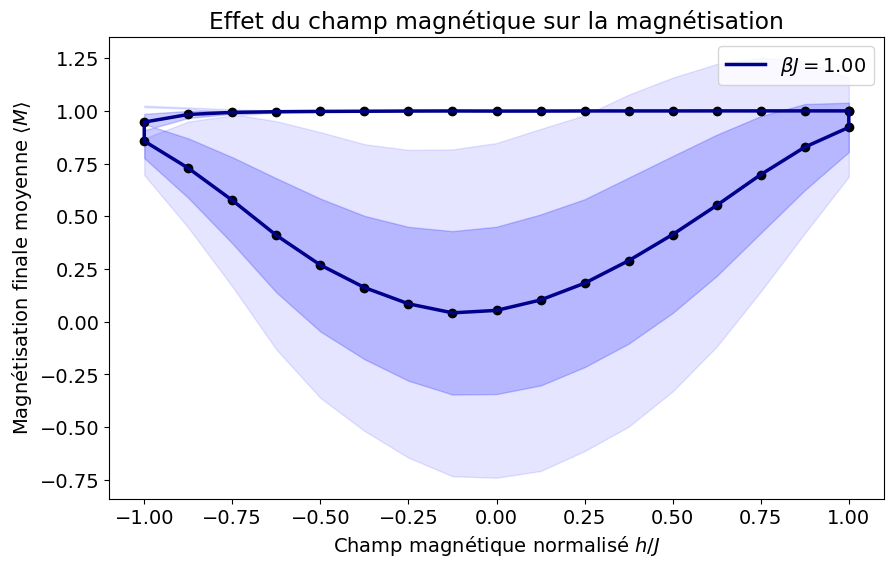

In [7]:
sim_id = len(fc.identify_files(top_dir+"/Data", keywords=[simulation_type]))
sim_folder = top_dir + "/Data/" + simulation_type + f"_{fc.fill_index(sim_id)}"
print(sim_folder)
if enreg:
    fc.create_folder(sim_folder)

for betaJ in betaJ_vec:

    print("betaJ : ", betaJ)

    filename = sim_folder + "/" + f"simul_betaJ={betaJ:.2f}"  # Juste le noyau du nom de fichier
    mag_data, Ef_data, grille_data = run_batch_simulations(h_vec, n_seeds=n_seeds, betaJ=betaJ, base_path=filename, enreg=enreg)

    h_vec_filtered = h_vec[branche_n_points:]
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]


    if close_loop: 
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

    plt.figure(figsize=(10,6))
    plt.plot(h_vec_filtered, mean_mag_filtered, color="darkBlue", linewidth=2.5, label=r"$\beta J = $" + f"{betaJ:.2f}")
    plt.fill_between(h_vec_filtered, 
                    mean_mag_filtered - std_mag_filtered, 
                    mean_mag_filtered + std_mag_filtered, 
                    color="blue", alpha=0.2)#, label=r"Variabilité ($\pm 1$ écart-type)")
    plt.fill_between(h_vec_filtered, 
                    mean_mag_filtered - std_mag_filtered*2, 
                    mean_mag_filtered + std_mag_filtered*2, 
                    color="blue", alpha=0.1)#, label=r"Variabilité ($\pm 1$ écart-type)")
    plt.scatter(h_vec_filtered, mean_mag_filtered, color="black")
    plt.xlabel(r"Champ magnétique normalisé $h/J$")
    plt.ylabel(r"Magnétisation finale moyenne $\langle M \rangle $")
    plt.title("Effet du champ magnétique sur la magnétisation")
    plt.xlim(1.1*h_low, 1.1*h_high)
    plt.legend()
    plt.show()

# 3.2 - Chargement des données de simulation


/tmp/ipykernel_35646/1592920136.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs


Chargement des données pour betaJ = 0.10
Chargement des données pour betaJ = 0.20
Chargement des données pour betaJ = 0.30
Chargement des données pour betaJ = 0.40
Chargement des données pour betaJ = 0.50
Chargement des données pour betaJ = 0.60
Chargement des données pour betaJ = 0.70
Chargement des données pour betaJ = 0.80
Chargement des données pour betaJ = 0.90
Chargement des données pour betaJ = 1.00


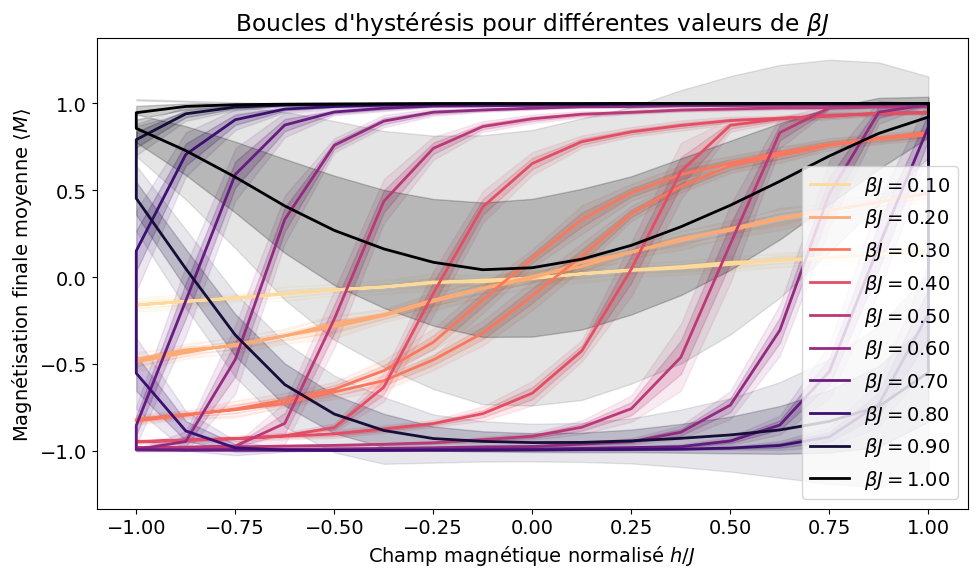

In [8]:
cmap = plt.cm.get_cmap('magma_r')  # Utiliser 'magma_r' pour inverser les couleurs
norm = plt.Normalize(vmin=min(betaJ_vec)*0.25, vmax=max(betaJ_vec))

plt.figure(figsize=(10, 6))

# Parcourir les différentes valeurs de betaJ
for betaJ in betaJ_vec:
    color = cmap(norm(betaJ))

    print(f"Chargement des données pour betaJ = {betaJ:.2f}")

    # Chemin vers le fichier HDF5 correspondant à cette valeur de betaJ
    filename = os.path.join(sim_folder, f"simul_betaJ={betaJ:.2f}.h5")

    if not os.path.exists(filename):
        print(f"Fichier non trouvé : {filename}")
        continue

    # Charger les données depuis le fichier HDF5
    with h5py.File(filename, "r") as f:
        mag_data = f["M_f"][:]  # Magnétisation finale
        h_vec_loaded = f["h"][:]  # Champ magnétique utilisé

    # Calculer la moyenne et l'écart-type de la magnétisation
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)

    # Filtrer les données pour retirer les premiers points
    h_vec_filtered = h_vec[branche_n_points:]
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]

    if close_loop:
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])

    # Tracer la courbe pour cette valeur de betaJ
    plt.plot(h_vec_filtered, mean_mag_filtered, color=color, linewidth=2, label=rf"$\beta J = {betaJ:.2f}$")
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - std_mag_filtered,
        mean_mag_filtered + std_mag_filtered,
        alpha=0.2, color=color
    )
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - 2*std_mag_filtered,
        mean_mag_filtered + 2*std_mag_filtered,
        alpha=0.1, color=color
    )

plt.xlabel(r"Champ magnétique normalisé $h/J$")
plt.ylabel(r"Magnétisation finale moyenne $\langle M \rangle$")
plt.title("Boucles d'hystérésis pour différentes valeurs de $\\beta J$")
plt.legend()
plt.tight_layout()
#plt.savefig("boucles_hystersis.pdf")
plt.show()

# 4 - Analyse

Tentons maintenant de calculer l'aire des boucles d'hystérésis pour chaque valeur de $\beta J$.

In [26]:
plt.rcParams['font.size'] = 16

Chargement des données pour betaJ = 0.20
Chargement des données pour betaJ = 0.30
Chargement des données pour betaJ = 0.40
Chargement des données pour betaJ = 0.50
Chargement des données pour betaJ = 0.60
Chargement des données pour betaJ = 0.70


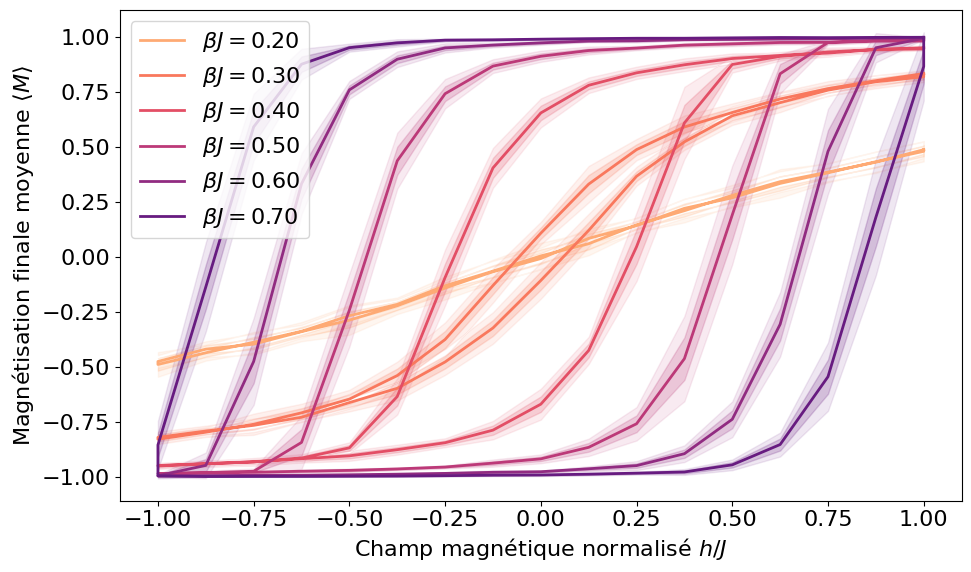

In [ ]:
betaJ_list = []
area_means = []
area_stds = []

plt.figure(figsize=(10, 6))

for betaJ in betaJ_vec[1:7]:
    color = cmap(norm(betaJ))

    print(f"Chargement des données pour betaJ = {betaJ:.2f}")

    # Chemin vers le fichier hdf5 correspondant
    filename = os.path.join(sim_folder, f"simul_betaJ={betaJ:.2f}.h5")

    if not os.path.exists(filename):
        print(f"Fichier non trouvé : {filename}")
        continue

    with h5py.File(filename, "r") as f:
        mag_data = f["M_f"][:]  # Magnétisation finale
        h_vec_loaded = f["h"][:]  # Champ magnétique utilisé

    # Calculer la moyenne et l'écart-type de la magnétisation
    mean_mag = np.mean(mag_data, axis=0)
    std_mag = np.std(mag_data, axis=0)

    # Filtrer les données
    h_vec_filtered = h_vec[branche_n_points:]
    mean_mag_filtered = mean_mag[branche_n_points:]
    std_mag_filtered = std_mag[branche_n_points:]

    mag_data_filtered = mag_data[:, branche_n_points:]  # Filtrer aussi chaque seed

    if close_loop:
        h_vec_filtered = np.concatenate([h_vec_filtered, [h_vec_filtered[0]]])
        mean_mag_filtered = np.concatenate([mean_mag_filtered, [mean_mag_filtered[0]]])
        std_mag_filtered = np.concatenate([std_mag_filtered, [std_mag_filtered[0]]])
        mag_data_filtered = np.concatenate([mag_data_filtered, mag_data_filtered[:, [0]]], axis=1)

    # Calcul des aires individuelles
    areas = np.array([
        np.abs(np.trapz(mag_data_filtered[i], h_vec_filtered))
        for i in range(mag_data_filtered.shape[0])
    ])

    # Moyenne et écart-type des aires
    area_mean = np.mean(areas)
    area_std = np.std(areas)

    betaJ_list.append(betaJ)
    area_means.append(area_mean)
    area_stds.append(area_std)

    # Tracer la courbe pour cette valeur de betaJ
    plt.plot(h_vec_filtered, mean_mag_filtered, color=color, linewidth=2, label=rf"$\beta J = {betaJ:.2f}$")
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - std_mag_filtered,
        mean_mag_filtered + std_mag_filtered,
        alpha=0.2, color=color
    )
    plt.fill_between(
        h_vec_filtered,
        mean_mag_filtered - 2*std_mag_filtered,
        mean_mag_filtered + 2*std_mag_filtered,
        alpha=0.1, color=color
    )

plt.xlabel(r"Champ magnétique normalisé $h/J$")
plt.ylabel(r"Magnétisation finale moyenne $\langle M \rangle$")
#plt.title("Boucles d'hystérésis pour différentes valeurs de $\\beta J$")
plt.legend()
plt.tight_layout()
plt.savefig("boucles_hystersis.pdf")
plt.show()


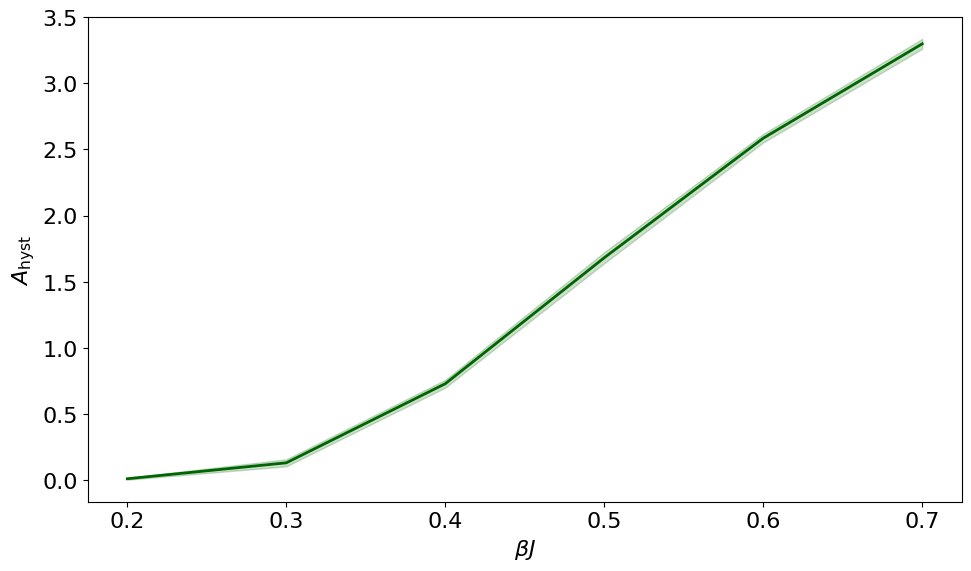

In [40]:
plt.figure(figsize=(10,6))
plt.plot(betaJ_list, area_means, color="darkGreen", linewidth=2, alpha=1)
plt.fill_between(betaJ_list, 
                 np.array(area_means) - np.array(area_stds), 
                 np.array(area_means) + np.array(area_stds), 
                 color="darkGreen", alpha=0.2, label=r"Variabilité ($\pm 1$ écart-type)")
plt.xlabel(r"$\beta J$")
plt.ylabel(r"$A_{\mathrm{hyst}}$")
#plt.title(r"Évolution de l'aire d'hystérésis avec $\beta J$")
plt.tight_layout()
plt.savefig("Aires_selon_betaJ.pdf")
plt.show()


# Code perdu

In [ ]:
def save_simulation_to_hdf5(filename, h_val, run_id, sim, lattices, spin_means, energy_list):
    with h5py.File(filename, 'a') as f:
        h_group_name = f"h={h_val:+.2f}"
        if h_group_name not in f:
            h_grp = f.create_group(h_group_name)
            h_grp.attrs["magnetic_field"] = h_val
        else:
            h_grp = f[h_group_name]

        run_group_name = f"run_{run_id:04d}"
        if run_group_name in h_grp:
            print(f"Warning: {h_group_name}/{run_group_name} already exists. Skipping save.")
            return

        run_grp = h_grp.create_group(run_group_name)
        run_grp.create_dataset("initial_lattice", data=sim.lattice)
        run_grp.create_dataset("final_lattice", data=lattices[-1])
        run_grp.create_dataset("energy", data=energy_list)
        run_grp.create_dataset("magnetization", data=spin_means)

        # Attributs du run
        run_grp.attrs["seed"] = sim.seed
        run_grp.attrs["betaJ"] = sim.betaJ
        run_grp.attrs["pourcentage_up"] = sim.up_perc
        run_grp.attrs["n_iter"] = sim.n_iter
        run_grp.attrs["convol"] = sim.convol

def run_batch_simulations(h_range, n_seeds, filename="results.h5"):
    betaJ = 1.0
    size = 64
    pourcentage_up = 0.5

    final_magnetizations = []
    std_magnetizations = []

    for h in tqdm(h_range, desc="Variation du champ magnétique"):
        mags = []
        for run_id in range(n_seeds):
            seed = np.random.randint(0, int(1e6))
            sim = Metropolis(
                n_iter=0,
                lattice_size=size,
                magnetic_field=h,
                betaJ=betaJ,
                pourcentage_up=pourcentage_up,
                convol="scipy",
                seed=seed
            )
            lattices, spin_means, energy_list = sim.run()
            save_simulation_to_hdf5(filename, h, run_id, sim, lattices, spin_means, energy_list)
            mags.append(spin_means[-1])

        final_magnetizations.append(np.mean(mags))
        std_magnetizations.append(np.std(mags))

    return h_range, final_magnetizations, std_magnetizations


In [ ]:
dataset_name = "run_0001"  # Remplacez par le nom du groupe que vous voulez lire

data= {}

with h5py.File(data_folder + "results.h5", "r") as file:
    print("Clefs du fichier :", list(file.keys()))
    
    if dataset_name in file:
        group = file[dataset_name]
        data= group
        print(f"Attributs du groupe {dataset_name}:", dict(group.attrs))
        initial_lattice = group["initial_lattice"][:]
        final_lattice = group["final_lattice"][:]
        energy = group["energy"][:]
        magnetization = group["magnetization"][:]
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Grille initiale")
        plt.imshow(initial_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.title("Grille finale")
        plt.imshow(final_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        print("Énergie :", energy)
        print("Magnétisation :", magnetization)
    else:
        print(f"Le groupe {dataset_name} n'existe pas dans le fichier.")